In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
df = pd.read_csv("data/smartnas_customer_reviews.csv")
df.head()

,review_id,username,content,rating,review_date
0,0ca3b1b1-8512-4333-8da7-78ba86888b86,Phal Dara,👍👍,4,2025-07-25 12:45:15
1,99d1d5ff-6297-4a84-a79e-9ffdecb21959,Phanna A,poor internet 🤡,1,2025-07-24 07:11:41
2,ba1b5ceb-e7e2-4f12-b4f6-deae12129498,Razy U,ដូចអាចម៍,1,2025-07-24 00:01:59
3,765f97ba-945b-43ee-ac23-0341fe8712c1,Sopheak Sok,ដូចអាចម៍,5,2025-07-23 07:57:03
4,71eec25e-cd5a-46ab-9a4b-107bb57bfc26,RW Media,"very slow, take long time to start the app",2,2025-07-23 07:17:02


In [3]:
print(df.isnull().sum())

review_id      0
username       0
content        0
rating         0
review_date    0
dtype: int64


In [4]:
import emoji
import regex

def clean_text(text):
    if not isinstance(text, str):
        return ''
    no_emoji = emoji.replace_emoji(text, replace='')
    no_khmer = regex.sub(r'\p{IsKhmer}+', '', no_emoji)
    return no_khmer.strip()

df['content'] = df['content'].apply(clean_text)
df = df[df['content'].str.strip() != ''].reset_index(drop=True)

In [5]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in ENGLISH_STOP_WORDS])

df['content'] = df['content'].apply(remove_stopwords)

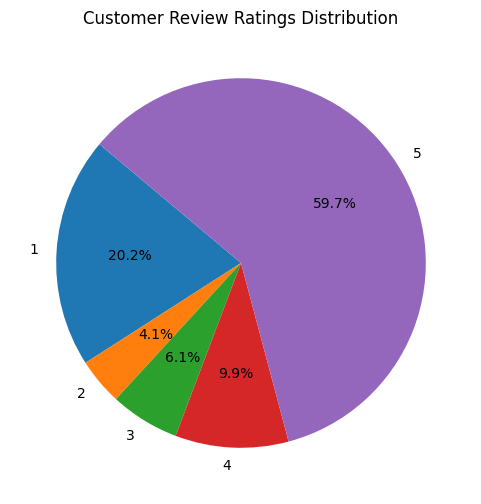

In [6]:
rating_counts = df['rating'].value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(
    rating_counts,
    labels=rating_counts.index,
    autopct='%1.1f%%',   
    startangle=140      
)
plt.title('Customer Review Ratings Distribution')
plt.show()

In [7]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment_score'] = df['content'].apply(get_sentiment)

def label_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)

In [8]:
df[['content', 'sentiment_score', 'sentiment']].head()

,content,sentiment_score,sentiment
0,poor internet,-0.40000,Negative
1,"slow, long time start app",-0.17500,Negative
2,good,0.70000,Positive
3,can't launch,0.00000,Neutral
4,Smart Company crazy? slow card? money runs qui...,-0.20873,Negative


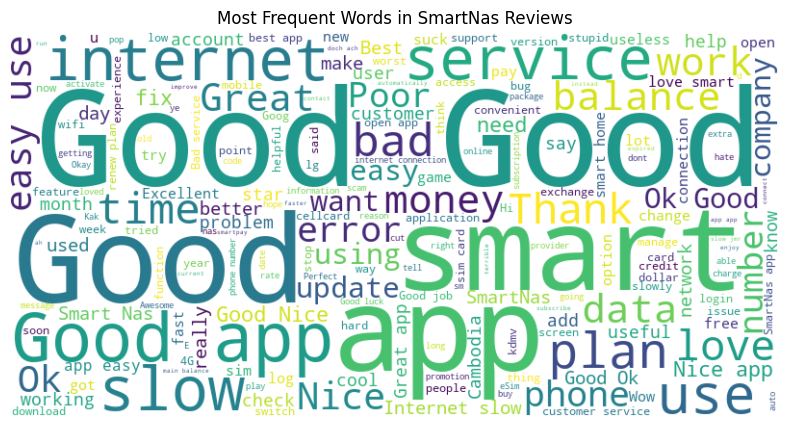

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned review texts
all_text = " ".join(df['content'])

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in SmartNas Reviews")
plt.show()

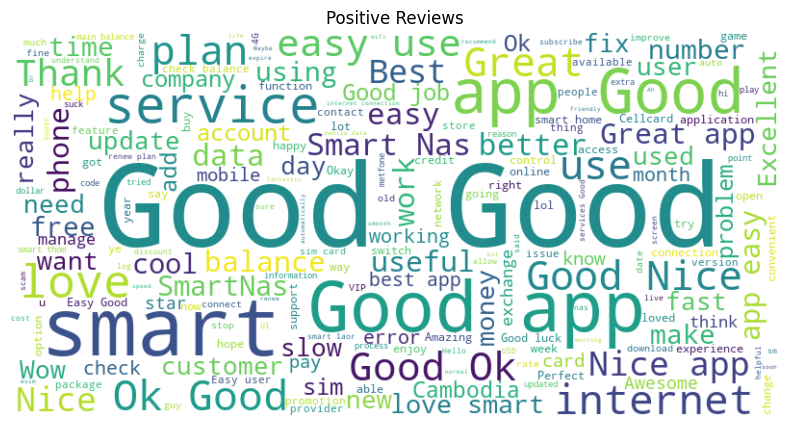

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_text = " ".join(df[df['sentiment'] == 'Positive']['content'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')
plt.show()

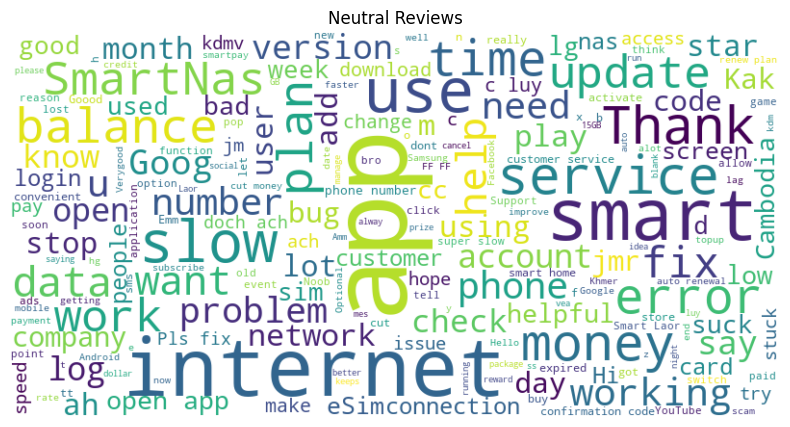

In [13]:
neutral_text = " ".join(df[df['sentiment'] == 'Neutral']['content'])
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Reviews')
plt.show()

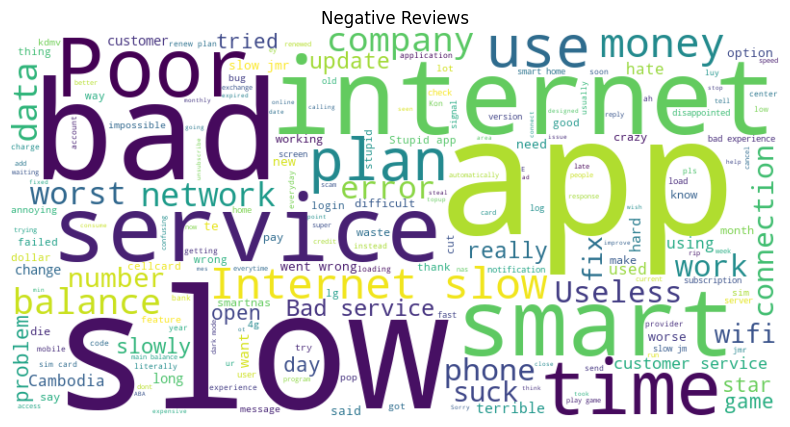

In [14]:
negative_text = " ".join(df[df['sentiment'] == 'Negative']['content'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')
plt.show()


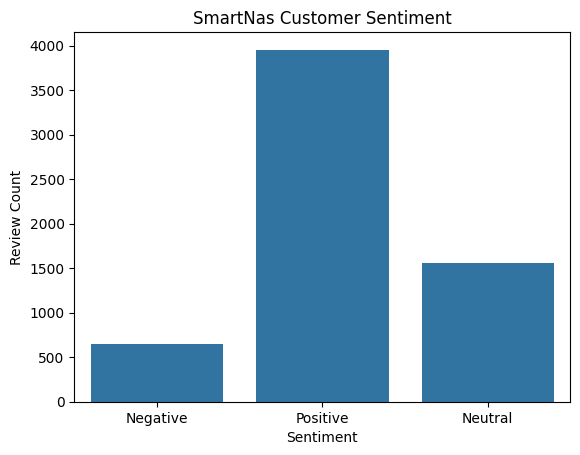

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment')
plt.title("SmartNas Customer Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Review Count")
plt.show()

In [16]:
import matplotlib.pyplot as plt

# Count each sentiment
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
Positive    3954
Neutral     1559
Negative     647
Name: count, dtype: int64


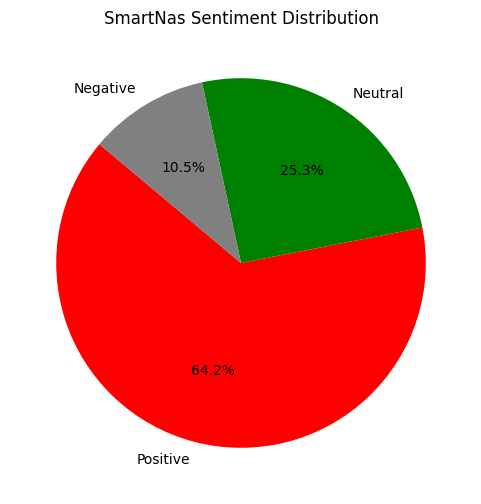

In [17]:
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['red','green','gray']
)
plt.title("SmartNas Sentiment Distribution")
plt.show()

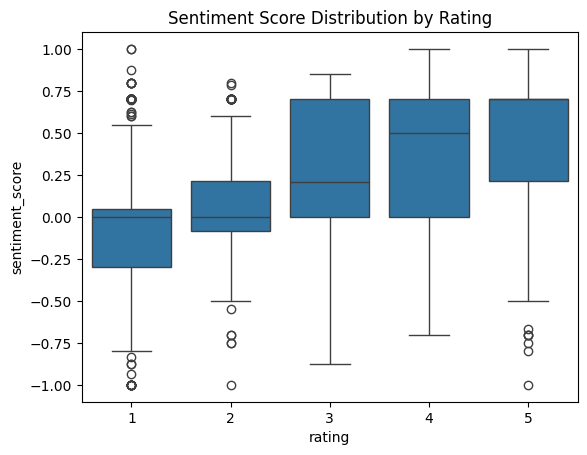

In [18]:
# Sentiment Breakdown by Rating
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df, x='rating', y='sentiment_score')
plt.title("Sentiment Score Distribution by Rating")
plt.show()

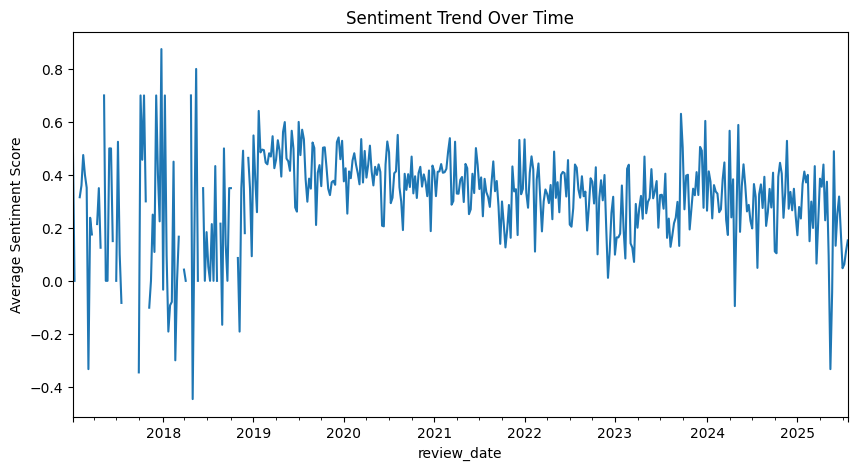

In [19]:
# Sentiment Over Time
# Show if things are getting better or worse

df['review_date'] = pd.to_datetime(df['review_date'])
df.set_index('review_date', inplace=True)
df.resample('W')['sentiment_score'].mean().plot(title="Sentiment Trend Over Time", figsize=(10, 5))
plt.ylabel("Average Sentiment Score")
plt.show()

<Axes: xlabel='sentiment', ylabel='rating'>

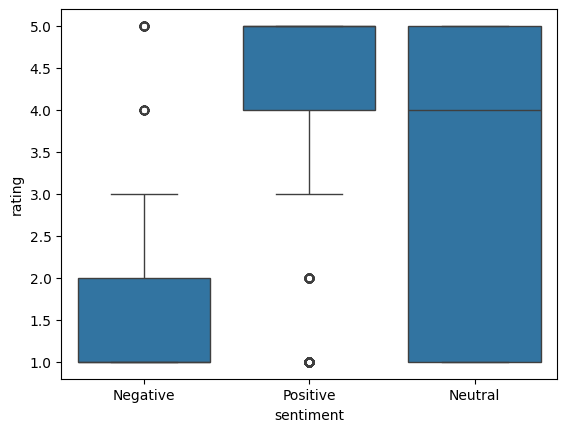

In [20]:
# Check correlation between star ratings and sentiment scores
sns.boxplot(x='sentiment', y='rating', data=df)

In [21]:
# Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# 2. Encode sentiment labels to numerical values
# e.g. Positive = 2, Neutral = 1, Negative = 0
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

In [23]:
# 3. Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = tfidf.fit_transform(df['content'])  # shape: (n_samples, n_features)

In [24]:
# 4. Optionally include `rating` as an additional feature
# We'll combine the TF-IDF matrix with rating as an extra column
from scipy.sparse import hstack

# Scale rating to match TF-IDF feature scale (optional, but cleaner)
df['rating_scaled'] = df['rating'] / 5.0

# Add rating as a column to the sparse matrix
X_all = hstack([X_text, np.array(df['rating_scaled']).reshape(-1, 1)])

In [25]:
# 5. Set your target (sentiment)
y = df['sentiment_encoded']

In [26]:
# 6. Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
# 7. Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Classification Report:

              precision    recall  f1-score   support

    Negative       0.90      0.77      0.83       129
     Neutral       0.81      0.94      0.87       312
    Positive       0.98      0.94      0.96       791

    accuracy                           0.92      1232
   macro avg       0.90      0.88      0.89      1232
weighted avg       0.93      0.92      0.93      1232



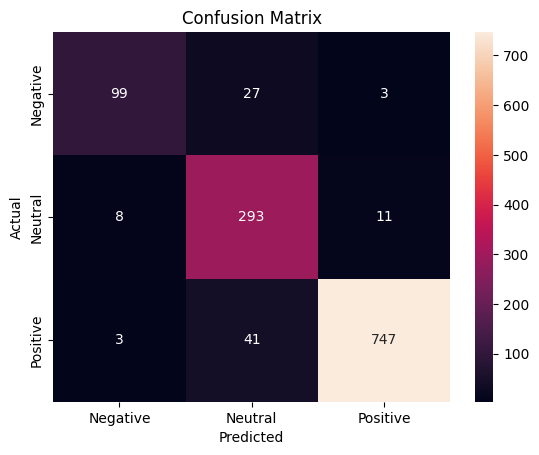

In [28]:
# 8. Predict and evaluate
y_pred = model.predict(X_test)

# Show performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()